# Algoritmos Genéticos Para Otimizar Rede de Entregadores

Objetivo: Dados uma seria de pedidos contento posições de origem e destino e tendo a localização dos entregadores, otimizar a alaocação dos entregadores de forma a atender os requisitos:

1. Reduzir a quilometragem geral percorrida pelos entregadores

Grupo:

- André Jackson Gomes Bessa - RM356320 - andrebessa@gmail.com
- Guilherme Silva - RM354130 - s.guisanto079@gmail.com
- Jose Eduardo - RM355857 - jeduardo.miranda@gmail.com
- Thiago - RM353588 - thiagodesa26@gmail.com


In [2]:
! pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 377.7 kB/s eta 0:00:00


In [150]:
from deap import base, creator, tools
from geopy.distance import geodesic # Para calcular distâncias entre pontos geográficos
import numpy as np
import pandas as pd
import random


In [151]:
# Definir os entregadores
entregadores = [
    {"id": 1, "localizacao": ( -23.55, -46.64 )},
    {"id": 2, "localizacao": ( -22.91, -43.21 )},
    {"id": 3, "localizacao": ( -23.91, -41.21 )},
    {"id": 4, "localizacao": ( -25.91, -44.21 )},
    {"id": 5, "localizacao": ( -26.91, -46.21 )}
]

# Definir os pedidos
pedidos = [
    {"id": 1, "origem": ( -23.56, -39.63 ), "destino": ( -33.57, -46.62 )},
    {"id": 2, "origem": ( -22.90, -40.20 ), "destino": ( -32.89, -45.19 )},
    {"id": 3, "origem": ( -21.90, -46.20 ), "destino": ( -31.89, -46.19 )},
    {"id": 4, "origem": ( -24.90, -45.20 ), "destino": ( -30.89, -43.19 )},
    {"id": 5, "origem": ( -25.90, -44.20 ), "destino": ( -29.89, -42.19 )},
    {"id": 6, "origem": ( -26.90, -43.20 ), "destino": ( -28.89, -40.19 )},
    {"id": 7, "origem": ( -27.90, -42.20 ), "destino": ( -27.89, -39.19 )},
    {"id": 8, "origem": ( -28.90, -43.20 ), "destino": ( -23.89, -38.19 )},
    {"id": 9, "origem": ( -30.90, -40.20 ), "destino": ( -28.89, -37.19 )},
    {"id": 10, "origem": ( -25.90, -40.20 ), "destino": ( -21.89, -35.19 )}
]

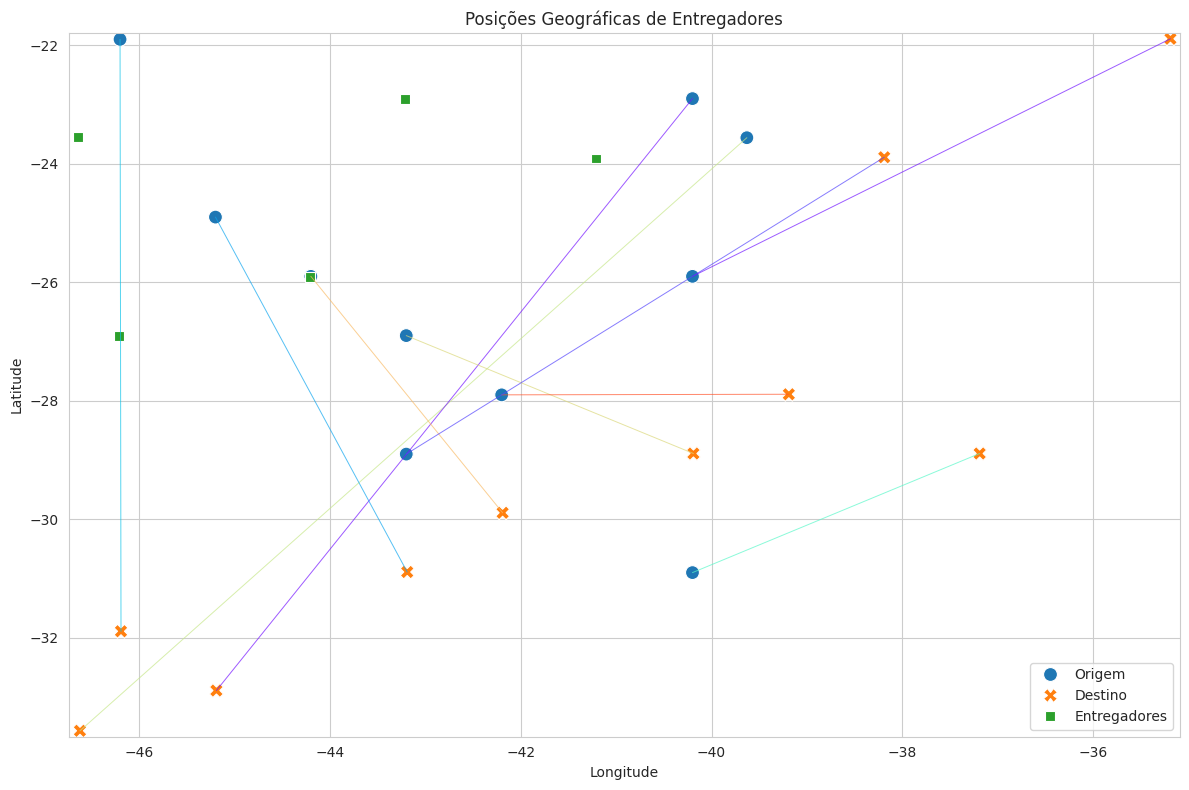

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import copy

origens = [pedido['origem'] for pedido in pedidos]
destinos = [pedido['destino'] for pedido in pedidos]
localizacoes_entregadores = [entregador['localizacao'] for entregador in entregadores]


# Suponha que você tenha os dados em listas ou dicionários
# origens = [(lat1, lon1), (lat2, lon2), ...]
# destinos = [(lat1, lon1), (lat2, lon2), ...]

# Criar DataFrames para origens e destinos
df_origens = pd.DataFrame(origens, columns=['Latitude', 'Longitude'])
df_origens['Tipo'] = 'Origem'

df_destinos = pd.DataFrame(destinos, columns=['Latitude', 'Longitude'])
df_destinos['Tipo'] = 'Destino'

df_entregadores = pd.DataFrame(localizacoes_entregadores, columns=['Latitude', 'Longitude'])
df_entregadores['Tipo'] = 'Entregadores'

# Combinar os DataFrames
df = pd.concat([df_origens, df_destinos, df_entregadores])

# Criar o gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Tipo', style='Tipo', s=100)

# Gerar uma lista de cores aleatória
num_origens = len(origens)
random.seed(42)
colors = [plt.cm.rainbow(random.random()) for _ in range(num_origens)]

# Adicionar linhas conectando origens e destinos
for color, ((orig_lat, orig_lon), (dest_lat, dest_lon)) in zip(colors, zip(origens, destinos)):
    plt.plot([orig_lon, dest_lon], [orig_lat, dest_lat], color=color, linewidth=0.7, alpha=0.7)

# # Adicionar linhas conectando origens e destinos
#for (orig_lat, orig_lon), (dest_lat, dest_lon) in zip(origens, destinos):
#  plt.plot([orig_lon, dest_lon], [orig_lat, dest_lat], 'b-', linewidth=0.5, alpha=0.5)

# Personalizar o gráfico
plt.title('Posições Geográficas de Entregadores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='')

# Ajustar os limites do gráfico para mostrar todas as posições
plt.xlim(df['Longitude'].min() - 0.1, df['Longitude'].max() + 0.1)
plt.ylim(df['Latitude'].min() - 0.1, df['Latitude'].max() + 0.1)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [153]:
# Gear população inicial (aqui podemos começar random ou hotstart (NN, convex hull etc))

# Gerando uma lista randomica distribuíndo um entregador para cada pedido
def entregador_pedido():
    chromossome = []
    max = int(len(pedidos)/len(entregadores))
    map_max = {}

    for i in range(len(entregadores)):
        map_max[i+1] = max

    while len(chromossome) < len(pedidos):
        entregador = random.choice(range(1, len(entregadores)+1))

        if map_max[entregador] != 0:
            chromossome.append(entregador)
            map_max[entregador] -= 1

    return chromossome

In [154]:
entregador_pedido()

[2, 2, 5, 5, 1, 4, 4, 3, 1, 3]

In [155]:
# Definir a função de fitness
# O atributo individuo é um objeto da classe Individuo
def fitness_function(individuo):
    total_distancia = 0
    chromossome = individuo[0]

    map_entregador_origem = {}
    data_stream = []

    #For que inderaja em uma lista e apresente a posicação da lista e o valor da posicação
    for pedido_id, entregador_id in enumerate(chromossome):
        pedido = pedidos[pedido_id] # Ajustar índice para começar de 0
        entregador = entregadores[entregador_id - 1]

        if entregador_id not in map_entregador_origem:
            map_entregador_origem[entregador_id] = entregador["localizacao"]

        entrega =  (map_entregador_origem[entregador_id], pedido["origem"], pedido["destino"])
        map_entregador_origem[entregador_id] = pedido["destino"]
        data_stream.append(entrega)


    for entrega in data_stream:
        total_distancia += geodesic(entrega[1], entrega[0]).km
        total_distancia += geodesic(entrega[2], entrega[1]).km

    return total_distancia,  # Retorna um tuple com o fitness

In [156]:
# Nova função de Crossover para não repetir mais de duas vezes
def crossover_no_repeats(ind1, ind2):
    possible_values = [entregador["id"] for entregador in entregadores]
    size = min(len(ind1), len(ind2))
    cxpoint = random.randint(1, size - 1)
    child1 = ind1[:cxpoint] + ind2[cxpoint:]
    child2 = ind2[:cxpoint] + ind1[cxpoint:]

    # Count occurrences of each value in children
    count1 = {value: child1.count(value) for value in possible_values}
    count2 = {value: child2.count(value) for value in possible_values}

    # Ensure no value repeats more than twice
    for value in possible_values:
        if count1.get(value, 0) > 2:
            index = [i for i, v in enumerate(child1) if v == value][2]
            child1[index] = random.choice([v for v in possible_values if v != value])
        if count2.get(value, 0) > 2:
            index = [i for i, v in enumerate(child2) if v == value][2]
            child2[index] = random.choice([v for v in possible_values if v != value])

    return child1, child2

In [157]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Criar o toolbox DEAP
toolbox = base.Toolbox()

# Configurar o toolbox
toolbox.register("entregador_pedido", entregador_pedido)

# Configurar crossover function
toolbox.register("mate", crossover_no_repeats)

# Um individuo é uma lista com o número de posicoes cada um referente a um pedido e o valor de cada posição é o entregador que vai entregar o pedido
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.entregador_pedido, n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [158]:
def execute(tamanho_populacao=10, cxpb=0.5, mutpb=0.2, ngen=5000, minfit=5000):
    populacao = toolbox.population(n=tamanho_populacao)
    results = {}

    # Avalia a população inicial
    fitnesses = list(map(toolbox.evaluate, populacao))
    for ind, fit in zip(populacao, fitnesses):
        ind.fitness.values = fit

    g = 0
    while g < ngen:
        g = g + 1

        # Seleciona os indivíduos para cruzamento
        offspring = toolbox.select(populacao, len(populacao))
        offspring = list(map(toolbox.clone, offspring))

        # Aplica crossover e mutação
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1[0], child2[0])
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant[0])
                del mutant.fitness.values

        # Avalia os indivíduos com fitness inválido
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Atualiza a população com os filhos evoluídos
        populacao[:] = offspring

        # Extrai os valores de fitness dos indivíduos da população
        fits = [ind.fitness.values[0] for ind in populacao]

        # Calcula estatísticas
        length = len(populacao)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        # Print das estatísticas a cada gerações
        print(f"-- Generation {g} --")
        print(f"  Min fitness: {min(fits)}")
        print(f"  Max fitness: {max(fits)}")
        print(f"  Mean fitness: {mean}")
        print(f"  Std fitness: {std}")

        # Armazena o melhor indivíduo da geração atual
        best_ind = tools.selBest(populacao, 1)[0]
        results[g] = best_ind

        print(f"  Best ind: {best_ind} \n")

        # Critério de parada opcional: se encontrar a solução ótima
        if min(fits) <= minfit:
            break

    return results

# Execução
execute_results = execute(tamanho_populacao=10, cxpb=0.8, mutpb=0.2, ngen=500)
print("\nBest individual found:")
print(execute_results[max(execute_results.keys())])

-- Generation 1 --
  Min fitness: 11828.380737840176
  Max fitness: 12278.838856829805
  Mean fitness: 11979.483783512862
  Std fitness: 159.93581016822867
  Best ind: [[3, 1, 3, 4, 2, 4, 1, 5, 2, 5]] 

-- Generation 2 --
  Min fitness: 11828.380737840176
  Max fitness: 12281.929639213397
  Mean fitness: 11926.764244864356
  Std fitness: 157.9604924784957
  Best ind: [[3, 1, 3, 4, 2, 4, 1, 5, 2, 5]] 

-- Generation 3 --
  Min fitness: 11828.380737840176
  Max fitness: 11828.380737840176
  Mean fitness: 11828.380737840174
  Std fitness: 0.00017263349150062197
  Best ind: [[3, 1, 3, 4, 2, 4, 1, 5, 2, 5]] 

-- Generation 4 --
  Min fitness: 11828.380737840176
  Max fitness: 11828.380737840176
  Mean fitness: 11828.380737840174
  Std fitness: 0.00017263349150062197
  Best ind: [[3, 1, 3, 4, 2, 4, 1, 5, 2, 5]] 

-- Generation 5 --
  Min fitness: 11828.380737840176
  Max fitness: 11828.380737840176
  Mean fitness: 11828.380737840174
  Std fitness: 0.00017263349150062197
  Best ind: [[3, 1, 3

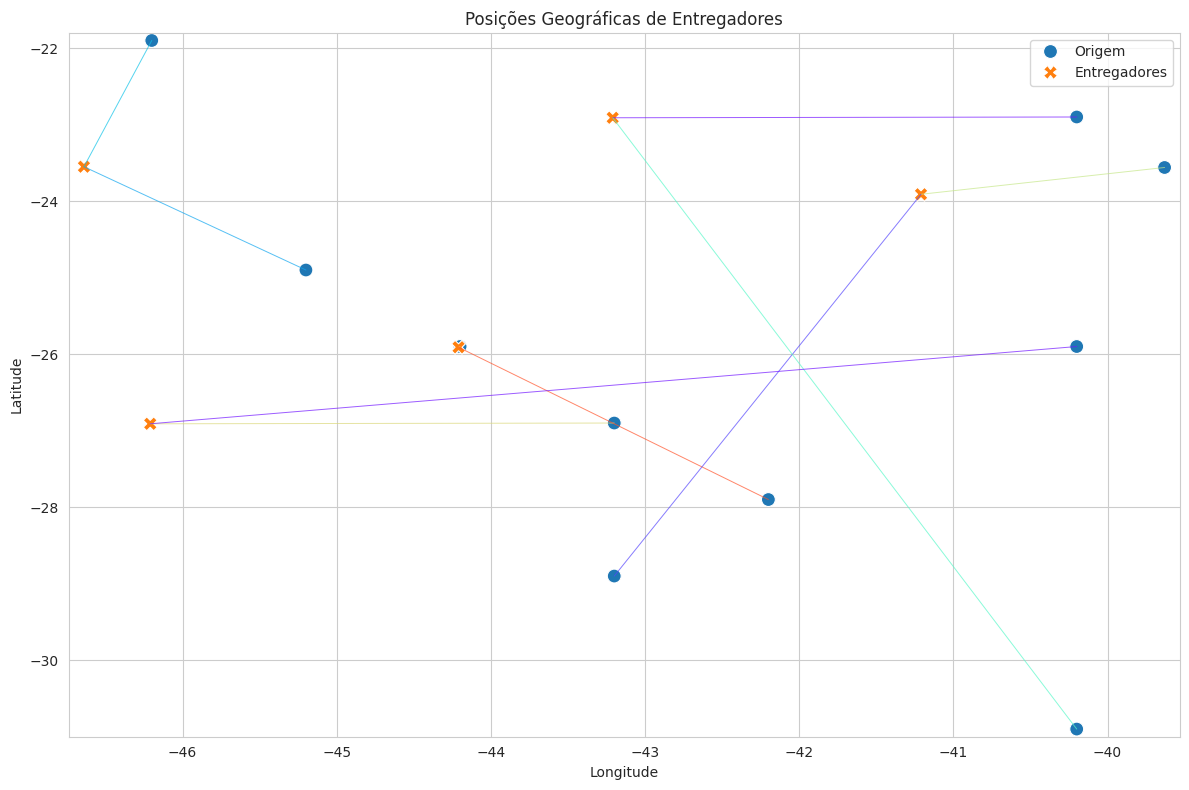

In [159]:
# Gráfico de qual entregador pegou cada entrega

# Combinar os DataFrames
df = pd.concat([df_origens, df_entregadores])

# Criar o gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Tipo', style='Tipo', s=100)

# Criar lista lat log entregas x entregador
entregas = execute_results[max(execute_results.keys())][0]
entregadores_entrega = []
for i in range(len(entregas)):
  entregadores_entrega.append(localizacoes_entregadores[entregas[i]-1])

# Gerar uma lista de cores aleatória
num_origens = len(origens)
random.seed(42)
colors = [plt.cm.rainbow(random.random()) for _ in range(num_origens)]

# Adicionar linhas conectando origens e destinos
for color, ((orig_lat, orig_lon), (dest_lat, dest_lon)) in zip(colors, zip(origens, entregadores_entrega)):
   plt.plot([orig_lon, dest_lon], [orig_lat, dest_lat], color=color, linewidth=0.7, alpha=0.7)

# Personalizar o gráfico
plt.title('Posições Geográficas de Entregadores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='')

# Ajustar os limites do gráfico para mostrar todas as posições
plt.xlim(df['Longitude'].min() - 0.1, df['Longitude'].max() + 0.1)
plt.ylim(df['Latitude'].min() - 0.1, df['Latitude'].max() + 0.1)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

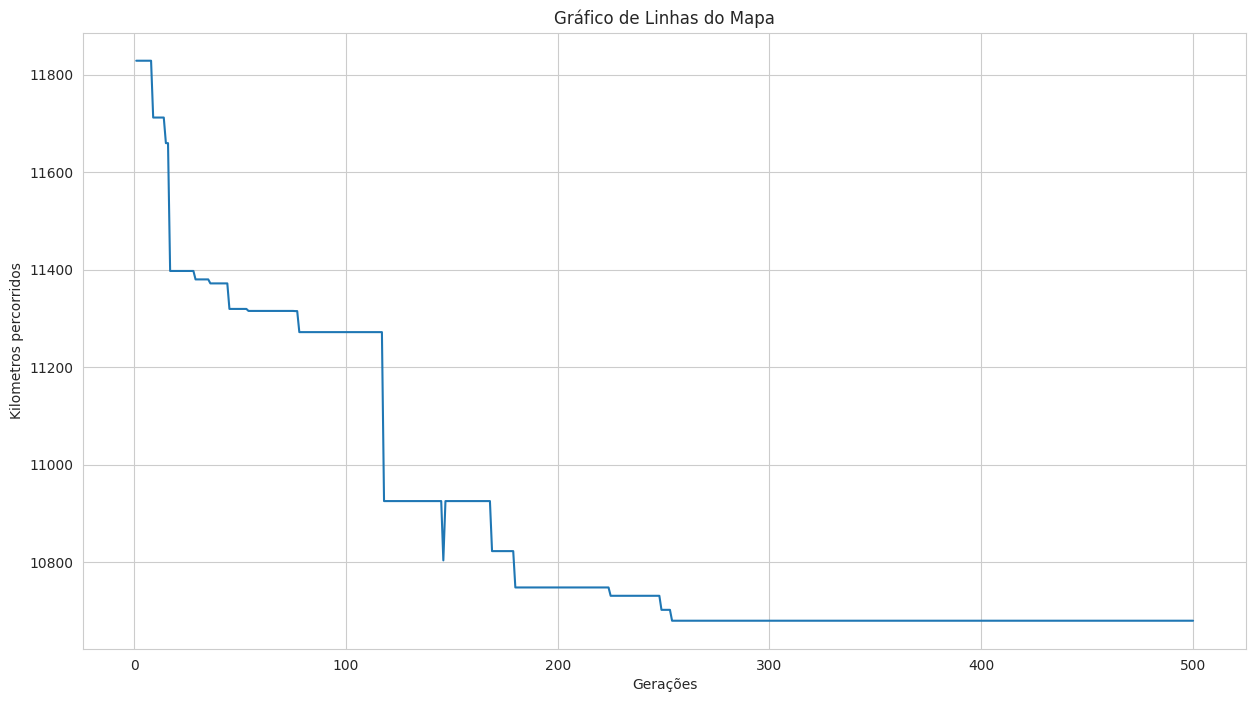

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Converter o mapa para um DataFrame
df = pd.DataFrame(list(execute_results.items()), columns=['Gerações', 'Kilometros percorridos'])

# Aplicar a função lambda aos valores
df['Kilometros percorridos'] = df['Kilometros percorridos'].map(lambda x: x.fitness.values[0])  # Substitua 'lambda x: x' pela sua função

# Configurar o estilo do Seaborn
sns.set_style("whitegrid")

# Criar o gráfico
plt.figure(figsize=(15, 8))
sns.lineplot(x='Gerações', y='Kilometros percorridos', data=df)

# Adicionar rótulos e título
plt.xlabel('Gerações')
plt.ylabel('Kilometros percorridos')
plt.title('Gráfico de Linhas do Mapa')

# Mostrar o gráfico
plt.show()
